## Importing Libraries && Loading the Dataset

In [254]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import pickle
import os

In [255]:
df = pd.read_csv('Data/Modified_Data.csv')
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,Occupation,RealisticSalary
0,619,France,Female,42,2,0.00,1,1,1,1,SENIOR CLERK TYPIST,89916.363636
1,608,Spain,Female,41,1,83807.86,1,0,1,0,Assistant Law Librarian,104729.161448
2,502,France,Female,42,8,159660.80,3,1,0,1,Dept Head II,136966.885102
3,699,France,Female,39,1,0.00,2,0,0,0,Chief Atty1 (Civil & Criminal),95425.454545
4,850,Spain,Female,43,2,125510.82,1,1,1,0,Dental Hygienist,147832.954748
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,0,IS Administrator 1,118247.272727
9996,516,France,Male,35,10,57369.61,1,1,1,0,"SENIOR INVESTIGATOR, OFFICE OF CITIZEN'S COMPL...",115457.603118
9997,709,France,Female,36,7,0.00,1,0,1,1,DIETETIC TECHNICIAN,115989.090909
9998,772,Germany,Male,42,3,75075.31,2,1,0,1,TRANSMISSION LINE SUPERVISOR I,130048.124137


In [256]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Occupation',
       'RealisticSalary'],
      dtype='object')

In [257]:
df.shape

(10000, 12)

## Preprocessing && Feature Engineering using Data Wrangler

In [258]:
df = df.drop(['Occupation'],axis=1)
df['Geography'] = OneHotEncoder(sparse_output=False,handle_unknown='ignore').fit_transform(df[['Geography']])
df['Gender'] = LabelEncoder().fit_transform(df[['Gender']])

d:\Client_Projects\Sir_Malik\ANN_Project\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [259]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited,RealisticSalary
0,619,1.0,0,42,2,0.00,1,1,1,1,89916.363636
1,608,0.0,0,41,1,83807.86,1,0,1,0,104729.161448
2,502,1.0,0,42,8,159660.80,3,1,0,1,136966.885102
3,699,1.0,0,39,1,0.00,2,0,0,0,95425.454545
4,850,0.0,0,43,2,125510.82,1,1,1,0,147832.954748
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1.0,1,39,5,0.00,2,1,0,0,118247.272727
9996,516,1.0,1,35,10,57369.61,1,1,1,0,115457.603118
9997,709,1.0,0,36,7,0.00,1,0,1,1,115989.090909
9998,772,0.0,1,42,3,75075.31,2,1,0,1,130048.124137


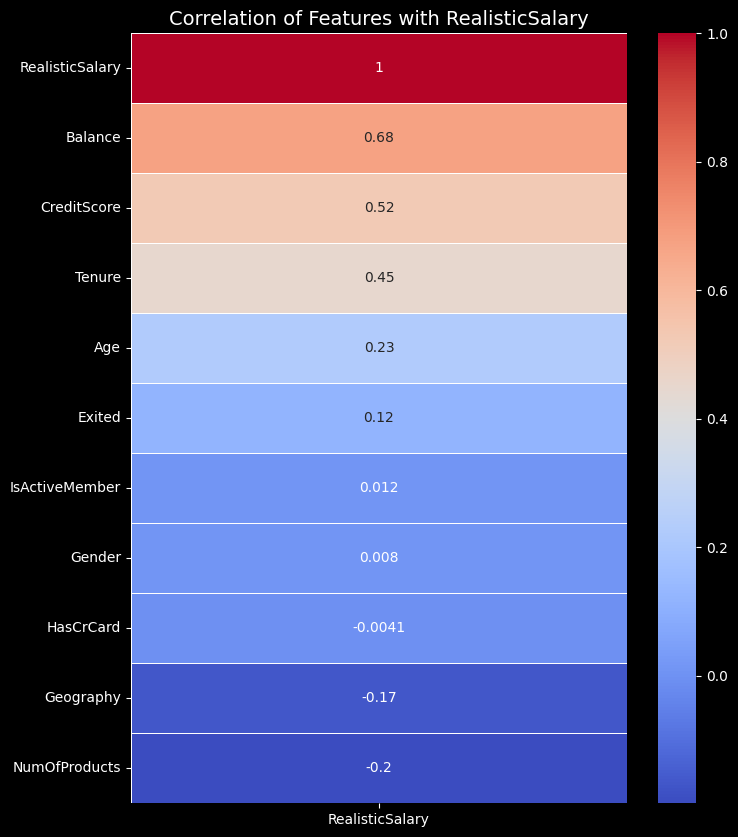

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric scalar columns
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation with RealisticSalary
corr = numeric_df.corr()["RealisticSalary"].sort_values(ascending=False)

# Heatmap
plt.figure(figsize=(8,10))
sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation of Features with RealisticSalary", fontsize=14)
plt.show()


## ANN Implementation

In [261]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, models
from sklearn.model_selection import train_test_split

X = StandardScaler().fit_transform(df.drop(['RealisticSalary'],axis=1))
y = df.RealisticSalary
# Example: split into X, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
def build_model(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")  # for regression (e.g., salary prediction)
    ])
    return model

# Build
model = build_model(X_train.shape[1])

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="mse",             # mean squared error for regression
    metrics=["mae"]          # mean absolute error
)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    "models/best_model.keras", monitor="val_loss", save_best_only=True, verbose=1
)

# Train
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/100


d:\Client_Projects\Sir_Malik\ANN_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


198/200 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15335067648.0000 - mae: 121861.0078
Epoch 1: val_loss improved from None to 14633763840.00000, saving model to models/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 15227272192.0000 - mae: 121399.9297 - val_loss: 14633763840.0000 - val_mae: 119040.4609
Epoch 2/100
181/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13101052928.0000 - mae: 112373.7109
Epoch 2: val_loss improved from 14633763840.00000 to 3851535104.00000, saving model to models/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 10247208960.0000 - mae: 98230.8516 - val_loss: 3851535104.0000 - val_mae: 61191.9062
Epoch 3/100
189/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2059265408.0000 - mae: 40913.8555
Epoch 3: val_loss improved from 3851535104.00000 to 153999248.00000, saving model to models/best_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1084033024.0000 - mae: 27201.2051 - val_loss: 153999248.0000 - val_mae: 10015.2393
E

In [262]:
from sklearn.metrics import r2_score

score = r2_score(y_test,model.predict(X_test))
score

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9893925854844571